## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
model = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from nltk import word_tokenize, pos_tag

nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')

!pip install swifter
import swifter 
from collections import Counter
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install contractions

In [3]:
import contractions

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Opening JSON file 
f = open("/content/drive/MyDrive/ML data /complaintsData/complaints-2021-05-14_08_16.json",'r')  # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.loads(f.read())
df=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.shape

(78313, 22)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign new column names
zip_iterator = zip(list(df.columns), [(x.replace("_","")).replace("source.","") for x in list(df.columns)])
df.rename(columns=dict(zip_iterator), inplace=True)
df.rename(columns={"complaintwhathappened":"complaints"},inplace=True)

# check changes column names
df.columns 

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely', 'complaints',
       'subissue', 'consumerconsentprovided'],
      dtype='object')

In [11]:
df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                     0
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [12]:
# check columns with blanks  

(df[:] == "").sum() 

index                          0
type                           0
id                             0
score                          0
tags                           0
zipcode                        0
complaintid                    0
issue                          0
datereceived                   0
state                          0
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse          0
subproduct                     0
timely                         0
complaints                 57241
subissue                       0
consumerconsentprovided        0
dtype: int64

In [13]:
#Assign nan in place of blanks in the complaints column

df.replace("", np.nan , inplace=True)

In [14]:
df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                 57241
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [15]:
# check again  : find % of of na columns wise 

df.isna().sum()/len(df.index)*100

index                       0.000000
type                        0.000000
id                          0.000000
score                       0.000000
tags                       86.081493
zipcode                     8.628197
complaintid                 0.000000
issue                       0.000000
datereceived                0.000000
state                       2.542362
consumerdisputed            0.000000
product                     0.000000
companyresponse             0.000000
company                     0.000000
submittedvia                0.000000
datesenttocompany           0.000000
companypublicresponse      99.994892
subproduct                 13.498397
timely                      0.000000
complaints                 73.092590
subissue                   59.117899
consumerconsentprovided     1.287143
dtype: float64

In [16]:
#Remove all rows where complaints column is nan

df.dropna(inplace = True, subset=["complaints"])

In [17]:
df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       17256
zipcode                     4645
complaintid                    0
issue                          0
datereceived                   0
state                        143
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      21070
subproduct                  2109
timely                         0
complaints                     0
subissue                    8176
consumerconsentprovided        0
dtype: int64

In [18]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [19]:
## check few complaints before cleaning 

df["complaints"].iloc[1]

'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.'

In [20]:
# Write your function here to clean the text and remove all the unnecessary elements.

def cleanText(text):
  text = text.lower()
  text = re.sub('\[|\]',"",text)    # Remove text in square brackets 
  text = re.sub('[^\w\s]',"",text)  # Remove punctuation
  text = re.sub('\w*\d\w*',"",text) # Remove words containing numbers
 # text = re.sub('[x]{2,}',"",text) # Remove words containing w
  return text.strip()

df["complaints"] = df["complaints"].swifter.apply(cleanText) 

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [21]:
## check few complaints after cleaning 

df["complaints"].iloc[1]

'i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me'

In [22]:
def check_word_frequency(text):
    return len(str(text).split(' '))

In [23]:
df['word_freq_complaints'] = df['complaints'].apply(check_word_frequency)
df['word_freq_complaints'].describe()

count    21072.000000
mean       253.904518
std        271.936512
min          1.000000
25%         97.000000
50%        181.000000
75%        321.000000
max       5556.000000
Name: word_freq_complaints, dtype: float64

In [24]:
#Write your function to Lemmatize the texts

#def lemmatize_text(text):
#  tokens = word_tokenize(text)
#  wordnet_lemmatizer = WordNetLemmatizer()
#  lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
#  lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
#  return " ".join(lemmatized)

sw = stopwords.words('english')
lem = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    tokens = list(filter(lambda x:x not in sw , tokens))
    processed_token = []
    for w,pos in pos_tag(tokens):
        try:
            processed_token.append(lem.lemmatize(w,pos[0].lower()))
        except:
            processed_token.append(lem.lemmatize(w))
    processed_text = ' '.join(processed_token)
    return processed_text

In [25]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemmatized complaints'] =  df['complaints'].swifter.apply(lemmatize_text)


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [26]:
df_clean = df[['complaints' , 'lemmatized complaints']].copy()
df_clean.head()

,complaints,lemmatized complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...
10,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [32]:
#Write your function to extract the POS tags 

def extract_POS_tags(text):
  nouns =  [token for token, pos in pos_tag(word_tokenize(text)) if pos.startswith('N')]
  #sent_nouns = " "
  #for word in nouns:
  #  sent_nouns = "".join(word)
  #sent_nouns =  ' '.join(nouns)
  #print(sent_nouns)
  return ' '.join(nouns)

In [33]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] =  df['lemmatized complaints'].swifter.apply(extract_POS_tags)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [34]:
df_clean.head()

,complaints,lemmatized complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,xxxx xxxx card tell agent date information ord...
10,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book xxxx xxxx ticket come offer apply towards...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




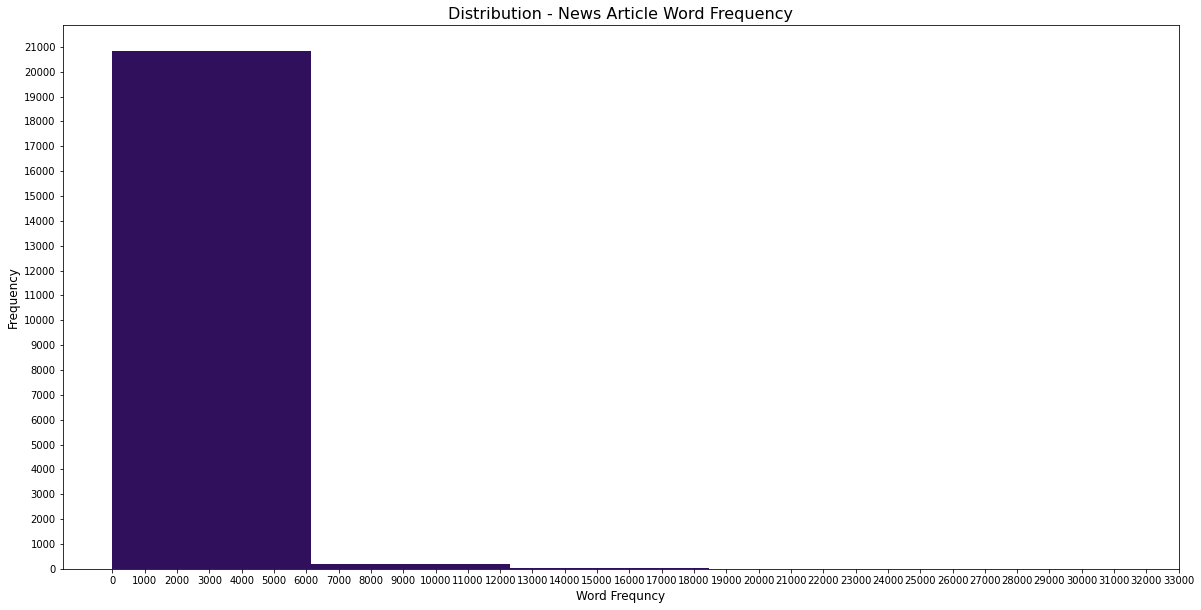

In [35]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean["complaint_length"] = df_clean["complaints"].apply(len)

fig = plt.figure(figsize=(20,10))

plt.hist(
    df_clean['complaint_length'],
    bins=5,
    color='#30105C'
)

plt.title('Distribution - News Article Word Frequency', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Frequncy', fontsize=12)
plt.yticks(np.arange(0, 22000, 1000))
plt.xticks(np.arange(0, 34000, 1000))

#file_name = 'hist'

'''
fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)
'''
plt.show()

  #### Most of the complaints are lenghty of more than 20k words  

#### Find the top 40 words by frequency among all the articles after processing the text.

In [58]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

p_text = df_clean['complaint_POS_removed'].str.split()

# Flaten the list of lists
#for sublist in p_text:
#  for item in sublist:
#    print(sublist)
p_text = [item for sublist in p_text for item in sublist]

# Top 40
top_40 = pd.DataFrame(
    Counter(p_text).most_common(40),
    columns=['word', 'frequency'])

top_40

,word,frequency
0,xxxx,171769
1,chase,54554
2,account,43713
3,credit,34088
4,bank,28646
5,card,26728
6,xxxxxxxx,23548
7,payment,21172
8,call,18407
9,charge,17112


In [59]:
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

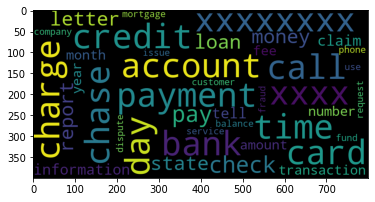

In [60]:
wordcloud.generate(' '.join([w for w in top_40["word"]]))
plt.imshow(wordcloud)

In [62]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
# df_clean['Complaint_clean'] = df_clean['complaint_POS_removed']

In [63]:
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...,475,morning name xxxx xxxx appreciate chase bank c...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,xxxx xxxx card tell agent date information ord...,337,xxxx xxxx card tell agent date information ord...
10,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...,210,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book xxxx xxxx ticket come offer apply towards...,1433,book xxxx xxxx ticket come offer apply towards...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,456,son check deposit chase account fund bank acco...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,650,chase card customer decade offer solicitation ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,xxxxxxxx call chas xxxx xxxx visa credit card ...,2067,xxxxxxxx call chas xxxx xxxx visa credit card ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,2296,pay risk consumer chase bank chase year trust ...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,2009,flawless credit chase credit card chase freedo...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the unigram frequency


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 


vectorizer = TfidfVectorizer(ngram_range = (2, 2))
X2 = vectorizer.fit_transform(df_clean.Complaint_clean)
scores = (X2.toarray())
print("\n\nScores : \n", scores)
  
# Getting top ranking features
sums = X2.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0, col] ))
ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords : \n", words.head(7))

In [ ]:
#Print the top 10 words in the bigram frequency

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [65]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

def remove_allXX(text):
  return re.sub('[x]{2,}',"",text)

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].apply(remove_allXX)


#df_clean['Complaint_clean'] = ' '.join(df_clean['Complaint_clean']).split()


In [66]:
#All masked texts has been removed
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...,475,morning name appreciate chase bank cardmembe...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,xxxx xxxx card tell agent date information ord...,337,card tell agent date information order upgra...
10,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...,210,card report application submit identity consen...
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book xxxx xxxx ticket come offer apply towards...,1433,book ticket come offer apply towards ticket ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,456,son check deposit chase account fund bank acco...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,650,chase card customer decade offer solicitation ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,xxxxxxxx call chas xxxx xxxx visa credit card ...,2067,call chas visa credit card provider ask cla...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,2296,pay risk consumer chase bank chase year trust ...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,2009,flawless credit chase credit card chase freedo...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [44]:
#Write your code here to initialise the TfidfVectorizer 



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [45]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [46]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



